In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt


In [2]:
# Define the time period for data analysis
years = 10
endDate = dt.date.today()
startDate = endDate - dt.timedelta(days = 365*years)

# Download the Adj Close rices for S&P 500 Financials (Sector) & S&P 500
tickers = ['^SP500-40', '^GSPC']
adj_close_df = yf.download(tickers, start= startDate, end= endDate)['Adj Close']

# 10-year US Treasury yield is used as the Risk Free Rate
risk_free_rate = yf.download('^TNX', start= startDate, end= endDate)['Adj Close']

adj_close_df.head()


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC,^SP500-40
Date,,
2014-09-12 00:00:00+00:00,1985.540039,314.100006
2014-09-15 00:00:00+00:00,1984.130005,314.190002
2014-09-16 00:00:00+00:00,1998.979980,315.320007
2014-09-17 00:00:00+00:00,2001.569946,316.709991
2014-09-18 00:00:00+00:00,2011.359985,320.040009


0.024193889312446117


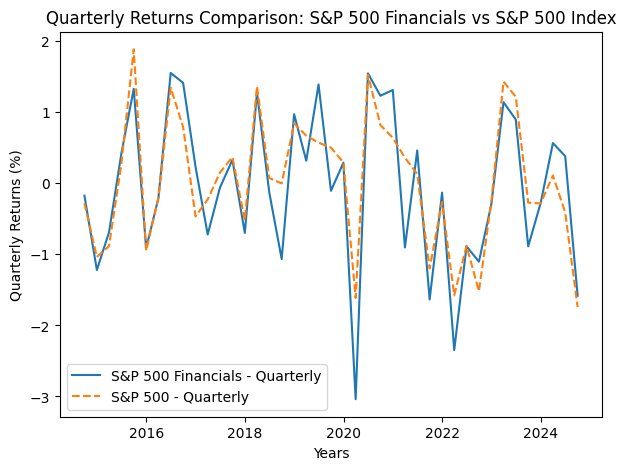

In [25]:
# Calculate daily log returns for both & Drop NA
daily_log_returns = np.log(adj_close_df / adj_close_df.shift(1))
daily_log_returns = daily_log_returns.dropna()

# Mean risk-free rate 
Risk_free_rate = risk_free_rate.mean()/100

print(Risk_free_rate)

# Visualization of Quarterly Return Comparison

quarterly_returns = daily_log_returns.resample('3ME').last()

plt.figure(figsize=(7, 5))
plt.plot(quarterly_returns['^SP500-40']*100, label='S&P 500 Financials - Quarterly')
plt.plot(quarterly_returns['^GSPC']*100, linestyle = '--', label='S&P 500 - Quarterly')
plt.title('Quarterly Returns Comparison: S&P 500 Financials vs S&P 500 Index')
plt.xlabel('Years')
plt.ylabel('Quarterly Returns (%)')
plt.legend()
plt.show()


In [4]:
# 1. Standard Deviation

volatility_financial = daily_log_returns['^SP500-40'].std() * np.sqrt(252)  # Annualized volatility
volatility_financial

np.float64(0.22329642600851365)

Volatility = 22.33%

Volatility measures the extent of variation in the returns of the S&P 500 Financials sector over a year. It reflects the degree of risk associated with the sector.

The average annualized volatility for the S&P 500 Index is around 15-20%. A volatility of 22.33% for the S&P 500 Financials sector indicates higher risk compared to the broader market.

1.0673098173531534
1.0673098173531537


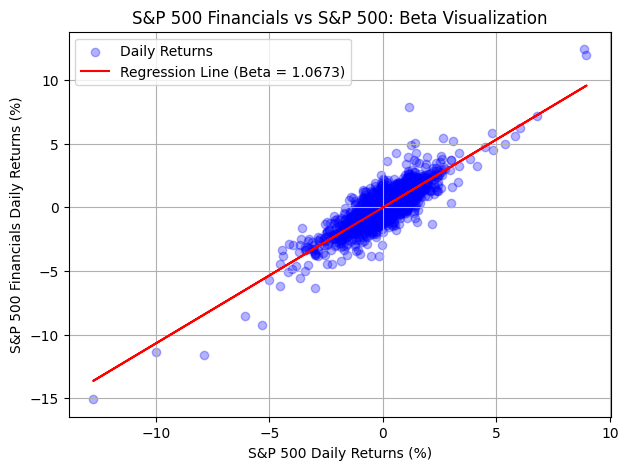

In [5]:
# 2. Beta

cov_matrix = np.cov(daily_log_returns['^SP500-40'], daily_log_returns['^GSPC']) *252
cov_matrix
beta_formula = cov_matrix[0,1]/cov_matrix[1,1]

print(beta_formula)

# Beta OLS
X = sm.add_constant(daily_log_returns['^GSPC'])
model = sm.OLS(daily_log_returns['^SP500-40'], X).fit()
beta_ols = model.params.iloc[1]

print(beta_ols)

# Scatter plot with regression line to visualize Beta
plt.figure(figsize=(7, 5))
plt.scatter(daily_log_returns['^GSPC']*100, daily_log_returns['^SP500-40']*100, alpha=0.3, label="Daily Returns", color="blue")

# Add the regression line using the OLS beta
X = sm.add_constant(daily_log_returns['^GSPC']*100)
model = sm.OLS(daily_log_returns['^SP500-40']*100, X).fit()
plt.plot(daily_log_returns['^GSPC']*100, model.fittedvalues, color="red", label=f'Regression Line (Beta = {beta_ols:.4f})')

plt.title('S&P 500 Financials vs S&P 500: Beta Visualization')
plt.xlabel('S&P 500 Daily Returns (%)')
plt.ylabel('S&P 500 Financials Daily Returns (%)')
plt.legend()
plt.grid(True)
plt.show()


Beta = 1.0673

A beta coefficient shows the volatility of an individual stock compared to the systematic risk of the entire market. Beta represents the slope of the line through a regression of data points. Each point represents an individual stock's returns against the market.

The market beta is 1. A beta above 1 indicates higher risk and potentially higher returns compared to the market. A beta of 1.0673 suggests the S&P 500 Financials sector is slightly more volatile than the market.

In [6]:
# 3. Expected Return (CAPM) Expected Return (ER) = Risk-Free Rate (RF) + Beta (b) * (Expected Market Return - Risk-Free Rate)

market_return = daily_log_returns['^GSPC'].mean()*252 #annualized
ER = Risk_free_rate + beta_formula * (market_return - Risk_free_rate)


print(market_return)
print(ER)


0.09903797134125504
0.1040757128325786


ER = 10.41%

Expected Return (ER) = Risk-Free Rate (RF) + Beta (b) * (Expected Market Return - Risk-Free Rate)

The capital asset pricing model, or CAPM, is a financial model that calculates the Expected Rate of Return for an asset or investment. CAPM does this by using the expected return on both the market and a risk-free asset, and the asset's correlation or sensitivity to the market (beta).

The historical average return of the S&P 500 Index is around 7-10%. An expected return of 10.41% is competitive and indicates a potentially attractive investment compared to the market average.

In [7]:
# 4. Sharpe Ratio

sharpe_ratio =(ER - Risk_free_rate)/ volatility_financial

print(sharpe_ratio)

0.35773892555309783


Sharpe ratio = 0.3577

The Sharpe ratio compares the return of an investment with its risk. It's a mathematical expression of the insight that excess returns over a period of time may signify more volatility and risk, rather than investing skill.

Sharpe Ratio= (Expected Return−Risk-Free Rate)/Volatility.

The Sharpe ratio is one of the most widely used methods for measuring risk-adjusted relative returns. It compares a fund's historical or projected returns relative to an investment benchmark with the historical or expected variability of such returns.

The greater a portfolio's Sharpe ratio, the better its risk-adjusted performance. A negative Sharpe ratio means the risk-free or benchmark rate is greater than the portfolio’s historical or projected return, or else the portfolio's return is expected to be negative. 

A Sharpe Ratio above 1 is considered good, indicating favorable risk-adjusted returns.
A ratio of 0.3577 is below this threshold, suggesting that while the sector offers a positive return relative to its risk, it may not be as efficient as other investments with higher Sharpe Ratios.

In [22]:
# Print calculated 
print('-' * 50)
print('Risk Analysis Metrics')
print('-' * 50)
print(f"Volatility (Annualized):        {volatility_financial:.4f} ({round(volatility_financial*100,2)}%)")
print(f"Beta (Formula):                 {beta_formula:.4f}")
print(f"Beta (OLS):                     {beta_ols:.4f}")
print(f"Sharpe Ratio:                   {sharpe_ratio:.4f}")
print(f"Expected Return (CAPM):         {ER:.4f} ({round(ER*100,2)}%)") 



--------------------------------------------------
Risk Analysis Metrics
--------------------------------------------------
Volatility (Annualized):        0.2233 (22.33%)
Beta (Formula):                 1.0673
Beta (OLS):                     1.0673
Sharpe Ratio:                   0.3577
Expected Return (CAPM):         0.1041 (10.41%)
